In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
# Paths and parameters
best_cars_model_path = 'best_cars_model.h5'
train_cars_dataset_path = 'data/cars_train/train'
test_cars_dataset_path = 'data/cars_train/test'
mean = np.array([0.4708, 0.4602, 0.4550])
std = np.array([0.2593, 0.2584, 0.2634])

In [24]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    horizontal_flip=True
)
train_datagen.mean = mean
train_datagen.std = std

test_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True
)
test_datagen.mean = mean
test_datagen.std = std

train_generator = train_datagen.flow_from_directory(
    train_cars_dataset_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_cars_dataset_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 6442 images belonging to 196 classes.
Found 1702 images belonging to 196 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: [ 23 194 124 127 109 122  60  56  71 182  52  16  34   3 166  60 182  93
  74  26 166 116 158 139  80  10  19 154  54 145  22 190  20 168  83  47
  48 136 189  45 154  98  57 122  69  80  36 173 166 184  50 189  65  99
 148  95   4  73  72 182 158  29  51 126]


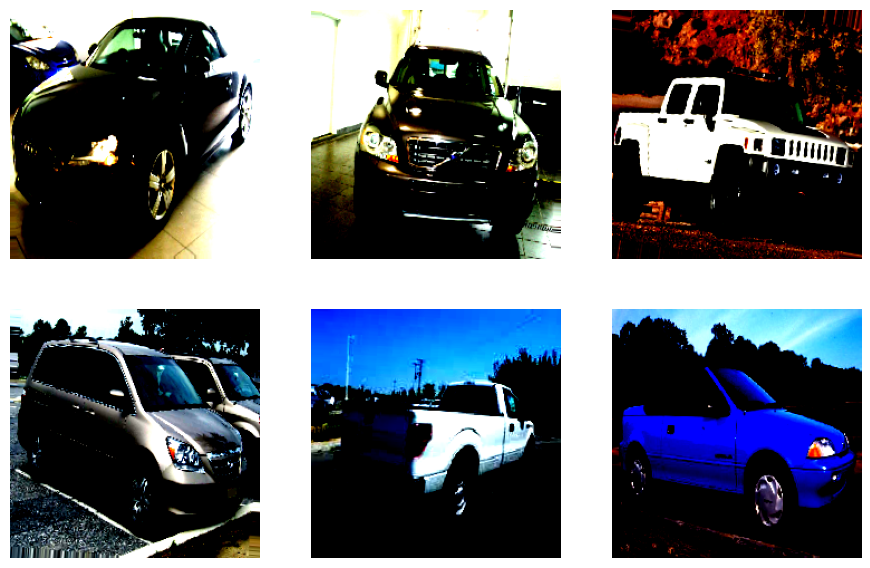

In [25]:
# Display some images
def show_transformed_images(generator, num_images=6):
    images, labels = next(generator)
    print(f"Labels: {np.argmax(labels, axis=1)}")
    plt.figure(figsize=(11,11))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

show_transformed_images(train_generator)

In [26]:
# Defining CNN model
num_classes = len(train_generator.class_indices)
input_shape = (224, 224, 3)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Callbacks for saving the best model
checkpoint = ModelCheckpoint(best_cars_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [28]:
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[checkpoint], verbose=1)

Epoch 1/10
101/101 [==============================] - ETA: 0s - loss: 5.4763 - accuracy: 0.0057
Epoch 1: val_accuracy improved from -inf to 0.00823, saving model to best_cars_model.h5


c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


101/101 [==============================] - 190s 2s/step - loss: 5.4763 - accuracy: 0.0057 - val_loss: 5.2774 - val_accuracy: 0.0082
Epoch 2/10
101/101 [==============================] - ETA: 0s - loss: 5.2778 - accuracy: 0.0087
Epoch 2: val_accuracy did not improve from 0.00823
101/101 [==============================] - 186s 2s/step - loss: 5.2778 - accuracy: 0.0087 - val_loss: 5.2762 - val_accuracy: 0.0082
Epoch 3/10
101/101 [==============================] - ETA: 0s - loss: 5.2779 - accuracy: 0.0073
Epoch 3: val_accuracy did not improve from 0.00823
101/101 [==============================] - 181s 2s/step - loss: 5.2779 - accuracy: 0.0073 - val_loss: 5.2760 - val_accuracy: 0.0082
Epoch 4/10
101/101 [==============================] - ETA: 0s - loss: 5.2732 - accuracy: 0.0087
Epoch 4: val_accuracy did not improve from 0.00823
101/101 [==============================] - 181s 2s/step - loss: 5.2732 - accuracy: 0.0087 - val_loss: 5.2725 - val_accuracy: 0.0071
Epoch 5/10
101/101 [===========

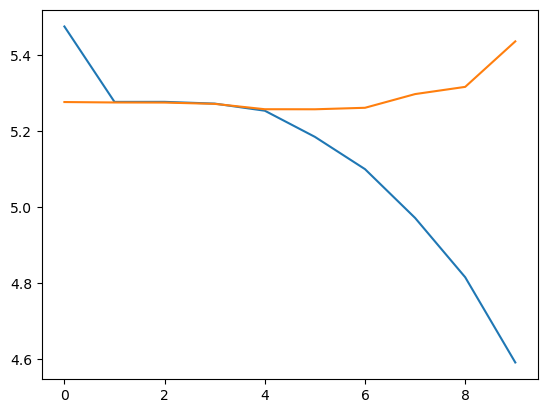

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [30]:
# Load the best model
best_model = load_model(best_cars_model_path)

# Evaluation
train_loss, train_acc = best_model.evaluate(train_generator, verbose=0)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_acc}')

test_loss, train_acc = best_model.evaluate(test_generator, verbose=0)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {train_acc}')

Train loss: 4.676719665527344
Train accuracy: 0.11269792169332504
Test loss: 5.298314094543457
Test accuracy: 0.014101057313382626


In [31]:
# Prediction and metrics
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

27/27 [==============================] - 15s 559ms/step


In [32]:
print('Confusion Matrix')
print(confusion_matrix(true_classes, predicted_classes))

Confusion Matrix
[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [33]:
print('Classification Report')
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

Classification Report
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.00      0.00      0.00         9
                             Acura Integra Type R 2001       0.00      0.00      0.00         9
                                   Acura RL Sedan 2012       0.00      0.00      0.00         7
                                   Acura TL Sedan 2012       0.07      0.11      0.08         9
                                  Acura TL Type-S 2008       0.00      0.00      0.00         9
                                  Acura TSX Sedan 2012       0.05      0.11      0.06         9
                              Acura ZDX Hatchback 2012       0.00      0.00      0.00         8
              Aston Martin V8 Vantage Convertible 2012       0.00      0.00      0.00         9
                    Aston Martin V8 Vantage Coupe 2012       0.00      0.00      0.00         9
                 

c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
